In [24]:
import networkx as nx
import pandas as pd
import numpy as np
import time
import tqdm
import pyarrow

def draw_graph(G, n_colormap=None, alpha=None, labels=None):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(G, seed = 1123)
    plt.figure(1, figsize=(10,10))
    e_colors = [G[u][v]['color'] for u,v in G.edges()]
    nx.draw(G, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=alpha, with_labels = labels, font_size = 8, font_weight = 'bold')
    plt.axis('off')
    plt.show()
# nx_g = nx.from_edgelist([(2,1), (2,3), (4,2), (3,4)])

# import matplotlib.pyplot as plt
# fig = plt.figure()
# nx.draw(nx_g, with_labels=True)

data_events = pd.read_parquet('data/Starboard/events.parquet')
# data_events = pd.read_csv('data/Starboard/events.csv')
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G1 = nx.Graph()

num_vessels = 0
G1_n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

In [25]:
data_events['start_time'] = pd.to_datetime(data_events['start_time'], format='%d/%m/%Y %H:%M')
data_events = data_events.sort_values(by='start_time').reset_index(drop=True)

In [17]:
data_events

,start_time,end_time,vessel_id,event_type,lat_n,lat_s,lon_e,lon_w,port_id,ectr_id,vessel_id2
0,2010-11-15 00:00:00,2010-11-15 13:59:00,4896,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11-15 00:01:00,2010-11-16 12:11:00,4806,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-11-15 00:02:00,2010-11-15 04:01:00,10210,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-11-15 00:02:00,2010-11-15 20:01:00,6990,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-11-15 00:02:00,2010-11-15 02:01:00,4543,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4687551,2012-11-13 23:20:00,2012-11-13 23:54:00,9388,ECTR,3.101800,3.088400,-151.538900,-151.552600,NaN,21808512.0,7533.0
4687552,2012-11-13 23:20:00,2012-11-13 23:54:00,7533,ECTR,3.101800,3.088400,-151.538900,-151.552600,NaN,21808512.0,9388.0
4687553,2012-11-13 23:35:00,2012-11-14 00:00:00,10749,FISH,46.153348,46.151052,139.017123,138.939763,NaN,NaN,NaN
4687554,2012-11-13 23:35:00,2012-11-14 00:00:00,10749,FISH,46.153348,46.151052,139.017123,138.939763,NaN,NaN,NaN


In [22]:
mask = (data_events['start_time'] >= '2011-11-15') & (data_events['start_time'] <= '2012-11-15')
data_events = data_events.loc[mask].reset_index(drop=True)


In [23]:
data_events

,start_time,end_time,vessel_id,event_type,lat_n,lat_s,lon_e,lon_w,port_id,ectr_id,vessel_id2
0,2011-11-15 00:00:00,2011-11-15 05:37:00,4921,FISH,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-11-15 00:01:21,2011-11-15 00:37:26,3085,None,43.191956,43.191956,27.904971,27.904971,662.0,NaN,NaN
2,2011-11-15 00:04:00,2011-11-15 07:06:00,3558,ECTR,0.000000,0.000000,0.000000,0.000000,NaN,14974815.0,10882.0
3,2011-11-15 00:04:00,2011-11-15 07:06:00,10665,ECTR,0.000000,0.000000,0.000000,0.000000,NaN,14974814.0,10882.0
4,2011-11-15 00:04:00,2011-11-15 07:06:00,3619,ECTR,0.000000,0.000000,0.000000,0.000000,NaN,14974816.0,10882.0
...,...,...,...,...,...,...,...,...,...,...,...
1262595,2012-11-13 23:20:00,2012-11-13 23:54:00,9388,ECTR,3.101800,3.088400,-151.538900,-151.552600,NaN,21808512.0,7533.0
1262596,2012-11-13 23:20:00,2012-11-13 23:54:00,7533,ECTR,3.101800,3.088400,-151.538900,-151.552600,NaN,21808512.0,9388.0
1262597,2012-11-13 23:35:00,2012-11-14 00:00:00,10749,FISH,46.153348,46.151052,139.017123,138.939763,NaN,NaN,NaN
1262598,2012-11-13 23:35:00,2012-11-14 00:00:00,10749,FISH,46.153348,46.151052,139.017123,138.939763,NaN,NaN,NaN


100%|██████████| 4687556/4687556 [04:59<00:00, 15645.46it/s]


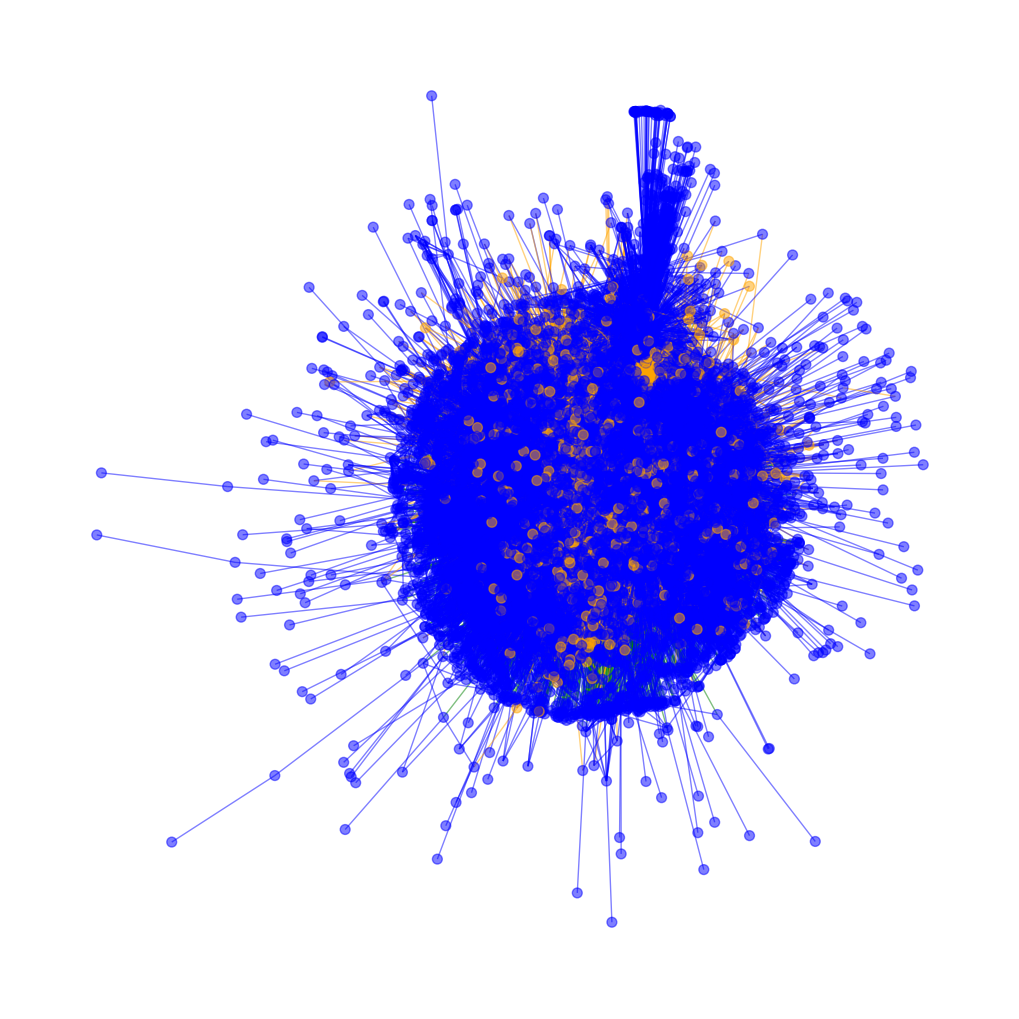

In [50]:
prog_bar = tqdm.tqdm(range(len(data_events)))
for ind, data in data_events.iterrows():
    init_vessel = data['vessel_id']
    sec_vessel = data['vessel_id2']
    port = data['port_id']
    event = data['event_type']

    # G1.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
    G1.add_node(init_vessel, name = 'vessel')
    G1_n_colormap[init_vessel] = 'blue'
    
    # if not np.isnan(sec_vessel):
    if not np.isnan(sec_vessel):# and sec_vessel in feature_dict:
        if sec_vessel in feature_dict:
            # label = feature_dict[sec_vessel]
            label = 'NA'
            G1.add_node(sec_vessel, name = 'vessel', label = label,
                       one_hot = eye[node_att_map[label]])
        else:
            G1.add_node(sec_vessel, name = 'vessel', label = 'NA',
                       one_hot = eye[node_att_map['NA']])

        G1.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
        G1_n_colormap[sec_vessel] = 'blue'

    elif not np.isnan(port):
        G1.add_node(port, name = 'port', label = 'Port',
                   one_hot = eye[node_att_map['Port']])
        G1.add_edge(init_vessel, port, event = 'PORT', color = 'orange')
        G1_n_colormap[port] = 'orange'
    
    else:
        G1.add_edge(init_vessel, 0, event = event, color = 'green')
        G1_n_colormap[0] = 'green'
    prog_bar.update(1)
    
prog_bar.close()

G1.nodes[0]['one_hot'] = eye[node_att_map['Fish']]

mapping = {node: ind for ind, node in enumerate(G1.nodes)}
rev_map = {ind: node for ind, node in enumerate(G1.nodes)}

H = nx.relabel_nodes(G1, mapping, copy = True)

node_att = nx.get_node_attributes(H, 'one_hot')
edge_att = nx.get_edge_attributes(H, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G1, seed = 1123)
plt.figure(1, figsize=(10,10))
e_colors = [G1[u][v]['color'] for u,v in G1.edges()]
nx.draw(G1, pos, node_color = G1_n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.5, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

In [56]:
G1.remove_edges_from(list(nx.selfloop_edges(G1)))
G1.remove_nodes_from(list(nx.isolates(G1)))
print(f'{nx.average_clustering(G1)} percent of neighbors are connected with each other')
print(len(G1.edges)/ len(G1.nodes) / len(G1.nodes))
print(len(max(nx.connected_components(G1), key=len)))
print(G1.number_of_nodes())
# Gwrong = nx.Graph()
# n_colormap = {}
# G1_copy = deepcopy(G1)
#G1_copy.remove_node(0)

len(G1.edges)

0.38586379966014056 percent of neighbors are connected with each other
0.0017633742728153134
11510
11510


233612

In [9]:
len(G1.nodes)

11510

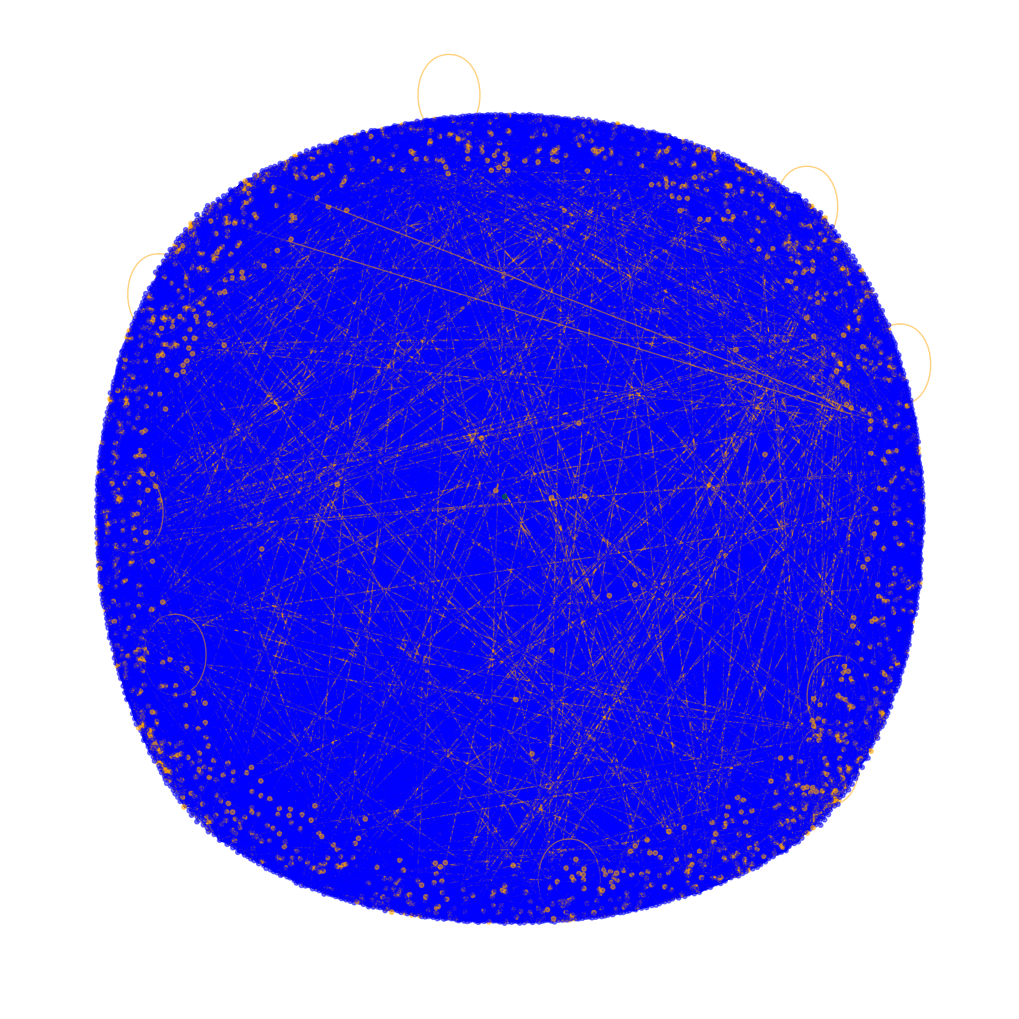

In [12]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G1, seed = 1123, k=2)
plt.figure(1, figsize=(10,10))
e_colors = [G1[u][v]['color'] for u,v in G1.edges()]
nx.draw(G1, pos, node_color = G1_n_colormap.values(), edge_color = e_colors, node_size=10, alpha=0.5, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()

In [3]:
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G2 = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
node_att_map['Fish'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'FISH': 1, 'PORT': 2}
eye = np.eye(len(node_att_map))

def add_to_g(path, G, n_colormap, right = True):
    data_events = pd.read_csv(path)
    for _, data in data_events.iterrows():
        init_vessel = data['vessel_id1']
        sec_vessel = data['vessel_id2']
        event = data['event_type']

        G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
        n_colormap[init_vessel] = 'blue'
        
        # if not np.isnan(sec_vessel):
        if event == 'ECTR':
            if sec_vessel in feature_dict:
                label = feature_dict[sec_vessel]
                G.add_node(sec_vessel, name = 'vessel', label = label,
                        one_hot = eye[node_att_map[label]])
            else:
                G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                        one_hot = eye[node_att_map['NA']])

            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightblue')
            n_colormap[sec_vessel] = 'blue'

        elif event == 'PORT':
            G.add_node(sec_vessel, name = 'port', label = 'Port',
                    one_hot = eye[node_att_map['Port']])
            
            if right:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'red')
            else:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'pink')
            n_colormap[sec_vessel] = 'red'
        
        else:
            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'green')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightgreen')
            n_colormap[0] = 'green'
    return G

path1 = 'res/right_data.csv'
G2 = add_to_g(path1, G2, n_colormap, True)
path2 = 'res/wrong_data.csv'
G2 = add_to_g(path2, G2, n_colormap, False)
G2.nodes[0]['one_hot'] = eye[node_att_map['Fish']]


mapping = {node: ind for ind, node in enumerate(G2.nodes)}
rev_map = {ind: node for ind, node in enumerate(G2.nodes)}

H2 = nx.relabel_nodes(G2, mapping, copy = True)

node_att = nx.get_node_attributes(H2, 'one_hot')
edge_att = nx.get_edge_attributes(H2, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H2.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G2)
plt.figure(1, figsize=(10,10))
e_colors = [G2[u][v]['color'] for u,v in G2.edges()]
nx.draw(G2, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.7, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

FileNotFoundError: [Errno 2] No such file or directory: 'res/right_data.csv'

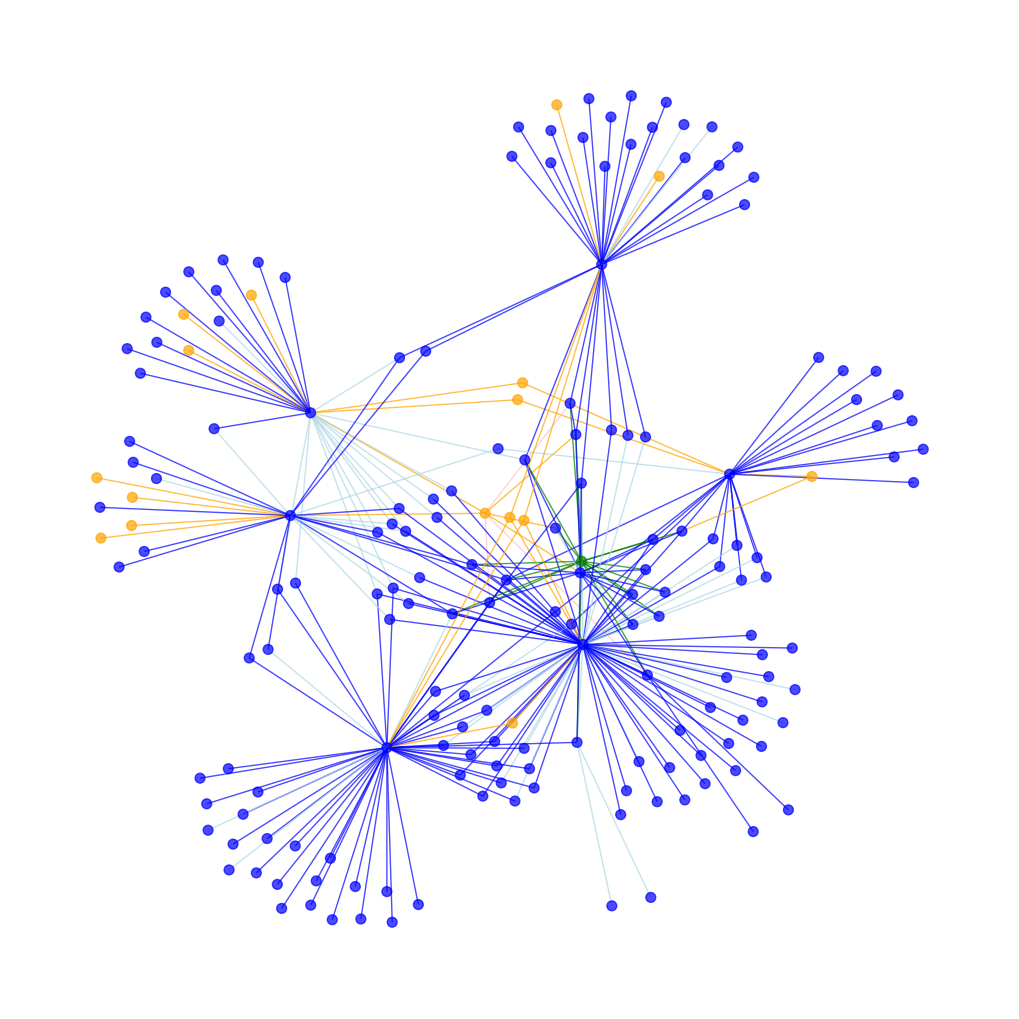

In [8]:
from copy import deepcopy

Gwrong = nx.Graph()
n_colormap = {}
G1_copy = deepcopy(G1)

path2 = 'res/wrong_data.csv'
Gwrong = add_to_g(path2, Gwrong, n_colormap, False)
G1_copy.update(Gwrong.edges(data=True), Gwrong.nodes(data=True))
draw_graph(G1_copy, G1_n_colormap, 0.7, False)

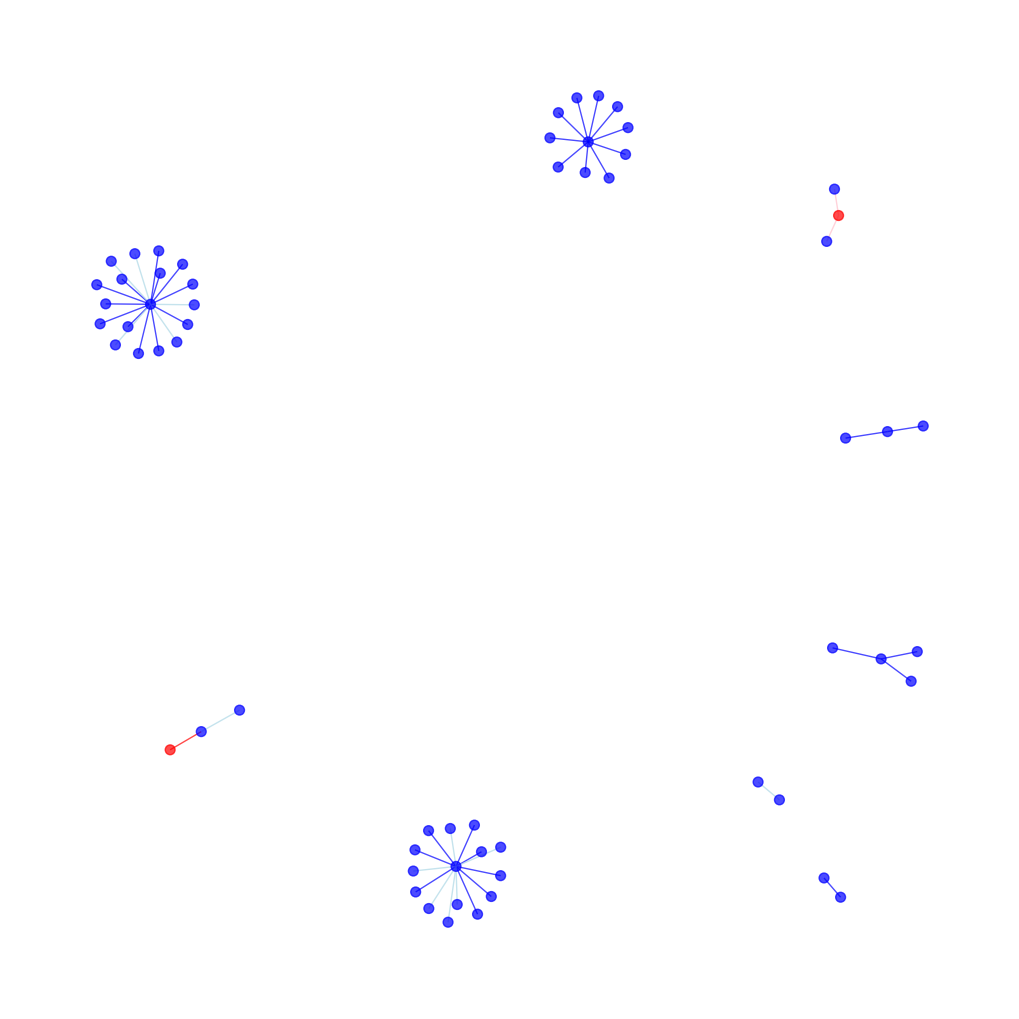

In [17]:
data_vessels = pd.read_csv('data/Starboard/vessels.csv')

t0 = time.time()
# Create Nodes and Edges
G2 = nx.Graph()

num_vessels = 0
n_colormap = {}
feature_dict = {x['vessel_id']: x['label'] for _, x in data_vessels.iterrows()}
node_att_map = {node: ind for ind, node in enumerate(set(data_vessels['label']))}
node_att_map['Port'] = len(node_att_map)
node_att_map['NA'] = len(node_att_map)
edge_att_map = {'ECTR': 0, 'PORT': 1}
eye = np.eye(len(node_att_map))

def add_to_g(path, G, n_colormap, right = True):
    data_events = pd.read_csv(path)
    for _, data in data_events.iterrows():
        init_vessel = data['vessel_id1']
        sec_vessel = data['vessel_id2']
        event = data['event_type']

        G.add_node(init_vessel, name = 'vessel', label = feature_dict[init_vessel])
        n_colormap[init_vessel] = 'blue'
        
        # if not np.isnan(sec_vessel):
        if event == 'ECTR':
            if sec_vessel in feature_dict:
                label = feature_dict[sec_vessel]
                G.add_node(sec_vessel, name = 'vessel', label = label,
                        one_hot = eye[node_att_map[label]])
            else:
                G.add_node(sec_vessel, name = 'vessel', label = 'NA',
                        one_hot = eye[node_att_map['NA']])

            if right:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'blue')
            else:
                G.add_edge(init_vessel, sec_vessel, event = event, color = 'lightblue')
            n_colormap[sec_vessel] = 'blue'

        elif event == 'PORT':
            G.add_node(sec_vessel, name = 'port', label = 'Port',
                    one_hot = eye[node_att_map['Port']])
            
            if right:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'red')
            else:
                G.add_edge(init_vessel, sec_vessel, event = 'PORT', color = 'pink')
            n_colormap[sec_vessel] = 'red'
        
    return G

path1 = 'res/right_data_fish.csv'
G2 = add_to_g(path1, G2, n_colormap, True)
path2 = 'res/wrong_data_fish.csv'
G2 = add_to_g(path2, G2, n_colormap, False)


mapping = {node: ind for ind, node in enumerate(G2.nodes)}
rev_map = {ind: node for ind, node in enumerate(G2.nodes)}

H2 = nx.relabel_nodes(G2, mapping, copy = True)

node_att = nx.get_node_attributes(H2, 'one_hot')
edge_att = nx.get_edge_attributes(H2, 'event')

x = np.array(list(node_att.values()))
edge_index = np.array(H2.edges()).T

import matplotlib.pyplot as plt
pos = nx.spring_layout(G2, seed=1123)
plt.figure(1, figsize=(10,10))
e_colors = [G2[u][v]['color'] for u,v in G2.edges()]
nx.draw(G2, pos, node_color = n_colormap.values(), edge_color = e_colors, node_size=50, alpha=0.7, with_labels = False, font_size = 8, font_weight = 'bold')
plt.axis('off')
plt.show()


t1 = time.time()

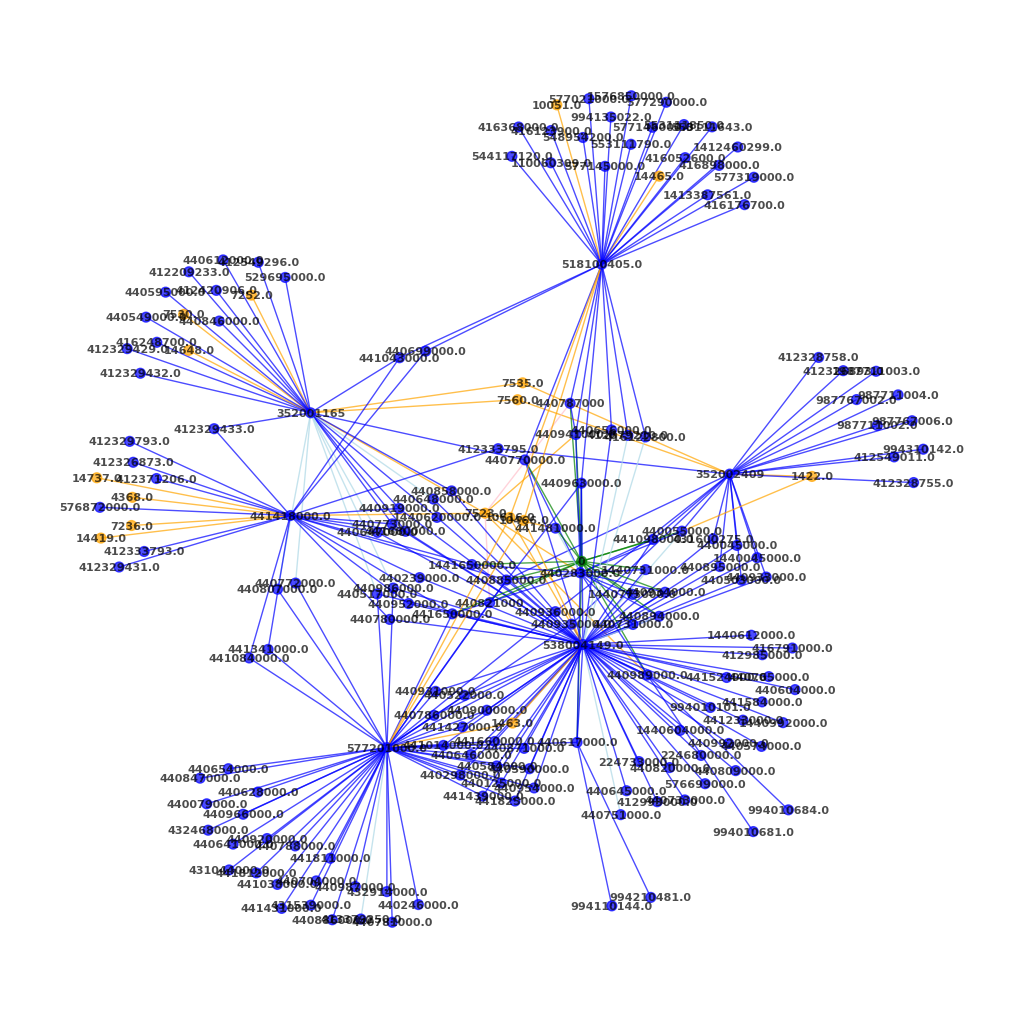

In [14]:
from copy import deepcopy

Gwrong = nx.Graph()
n_colormap = {}
G1_copy = deepcopy(G1)
#G1_copy.remove_node(0)

G1_copy_colormap = deepcopy(G1_n_colormap)

path2 = 'res/wrong_data_fish.csv'
Gwrong = add_to_g(path2, Gwrong, n_colormap, False)
G1_copy.update(Gwrong.edges(data=True), Gwrong.nodes(data=True))
del G1_copy_colormap[0]
draw_graph(G1_copy, G1_n_colormap, 0.7, True)

In [48]:
import pickle

with open('data/Starboard/adj_time_list.pickle', 'rb') as handle:
    adj_time_list = pickle.load(handle)

0.014857881136950905 percent of neighbors are connected with each other
0.0012318971215672136
13
516


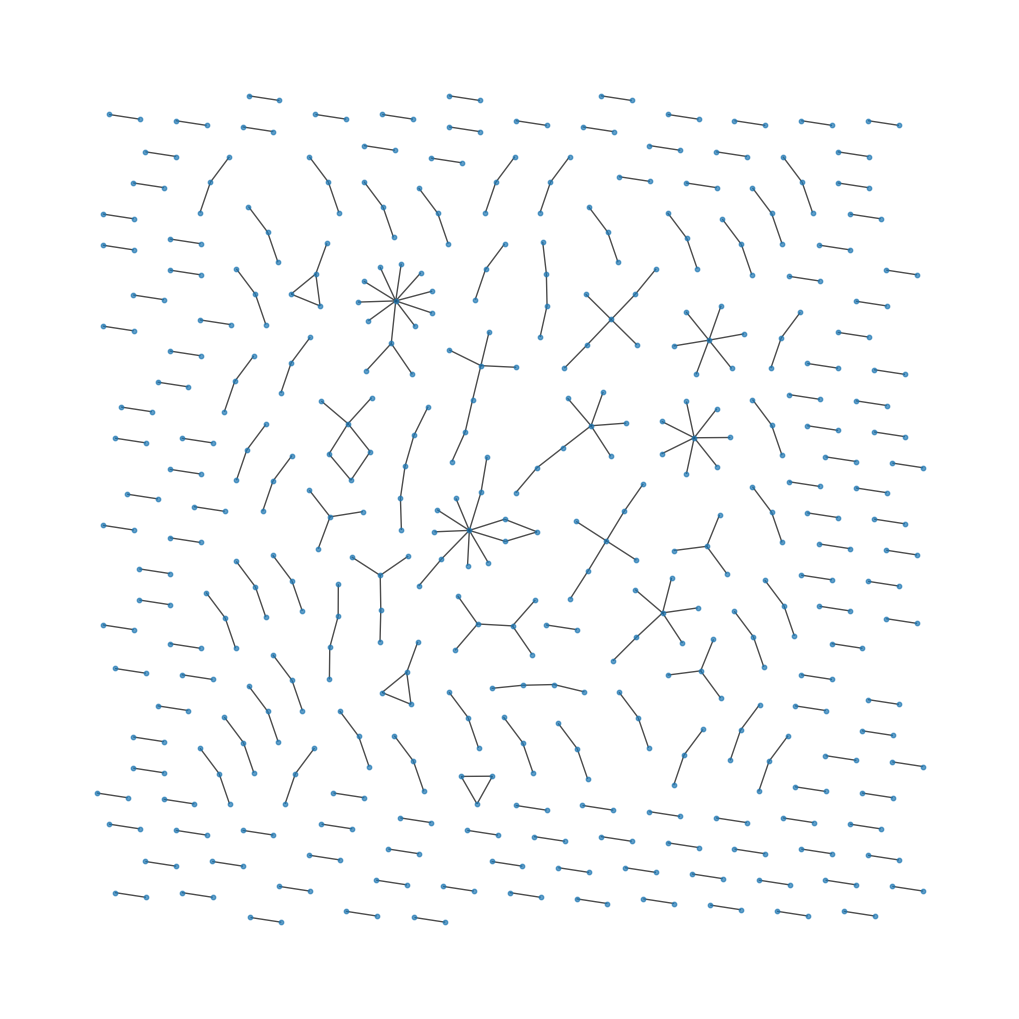

In [52]:
import scipy
import scipy.sparse

matr = adj_time_list[729]

G = nx.from_scipy_sparse_array(matr)
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))
print(f'{nx.average_clustering(G)} percent of neighbors are connected with each other')
print(len(G.edges)/ len(G.nodes) / len(G.nodes))
print(len(max(nx.connected_components(G), key=len)))
print(G.number_of_nodes())
# Gwrong = nx.Graph()
# n_colormap = {}
# G1_copy = deepcopy(G1)
#G1_copy.remove_node(0)

alpha = 0.7

import matplotlib.pyplot as plt
# pos = nx.spring_layout(G, seed = 1123, k=0.5)
pos = nx.nx_agraph.graphviz_layout(G, prog = 'neato')
plt.figure(1, figsize=(10,10))
nx.draw(G, pos, node_size=10, alpha=alpha, font_weight = 'bold')
plt.axis('off')
plt.show()

0.16250043378442297 percent of neighbors are connected with each other
0.010975096671419946
289
1116


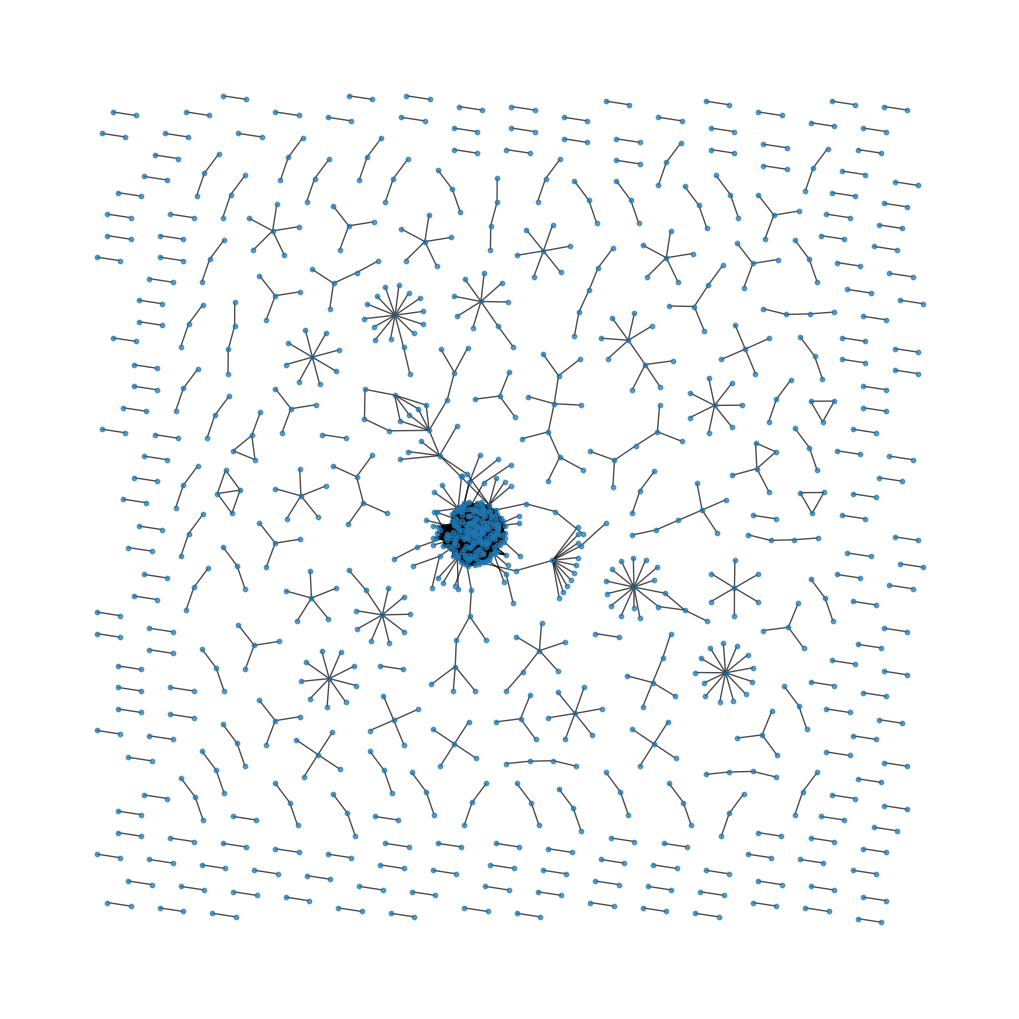

In [53]:
matr = adj_time_list[140]

G = nx.from_scipy_sparse_array(matr)
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))
print(f'{nx.average_clustering(G)} percent of neighbors are connected with each other')
print(len(G.edges)/ len(G.nodes) / len(G.nodes))
print(len(max(nx.connected_components(G), key=len)))
print(G.number_of_nodes())
# Gwrong = nx.Graph()
# n_colormap = {}
# G1_copy = deepcopy(G1)
#G1_copy.remove_node(0)

alpha = 0.7

import matplotlib.pyplot as plt
# pos = nx.spring_layout(G, seed = 1123, k=0.5)
pos = nx.nx_agraph.graphviz_layout(G, prog = 'neato')
plt.figure(1, figsize=(10,10))
nx.draw(G, pos, node_size=10, alpha=alpha, font_weight = 'bold')
plt.axis('off')
plt.show()